# showus

In [ ]:
#default_exp showus

In [ ]:
! pip install /kaggle/input/nlp-packages/datasets/datasets/fsspec-2021.4.0-py3-none-any.whl
! pip install datasets --no-index --find-links=file:///kaggle/input/coleridge-packages/packages/datasets
! pip install ../input/coleridge-packages/seqeval-1.2.2-py3-none-any.whl
! pip install ../input/coleridge-packages/tokenizers-0.10.1-cp37-cp37m-manylinux1_x86_64.whl
! pip install ../input/coleridge-packages/transformers-4.5.0.dev0-py3-none-any.whl

Processing /kaggle/input/nlp-packages/datasets/datasets/fsspec-2021.4.0-py3-none-any.whl
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.8.7
    Uninstalling fsspec-0.8.7:
      Successfully uninstalled fsspec-0.8.7
Looking in links: file:///kaggle/input/coleridge-packages/packages/datasets
Processing /kaggle/input/coleridge-packages/packages/datasets/datasets-1.5.0-py3-none-any.whl
Processing /kaggle/input/coleridge-packages/packages/datasets/huggingface_hub-0.0.7-py3-none-any.whl
Processing /kaggle/input/coleridge-packages/packages/datasets/tqdm-4.49.0-py2.py3-none-any.whl
Processing /kaggle/input/coleridge-packages/packages/datasets/xxhash-2.0.0-cp37-cp37m-manylinux2010_x86_64.whl
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
Processing /kaggle/input/coleridge-packages/seqeval-1.2.2-py3-none-any.whl
Processing /kaggle/input/coleridge-packages/tokenizers-0.10.

In [ ]:
#export
import os, shutil, time
from tqdm import tqdm
from pathlib import Path
import itertools
from functools import partial
import re
import json
import random
import numpy as np
import pandas as pd
import torch
from tokenizers.pre_tokenizers import BertPreTokenizer
import transformers, seqeval
from transformers import AutoTokenizer, DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer
from datasets import load_dataset, ClassLabel, load_metric

import matplotlib.pyplot as plt

# Utilities

In [ ]:
#export
Path.ls = lambda pth: list(pth.iterdir())

# Data I/O

In [ ]:
#export
def load_train_meta(pth, group_id=True):
    df = pd.read_csv(pth)
    if group_id:
        df = df.groupby('Id').agg({'pub_title': 'first', 
                                   'dataset_title': '|'.join, 
                                   'dataset_label': '|'.join, 
                                   'cleaned_label': '|'.join}).reset_index()
    return df

In [ ]:
pth = Path('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv')
df = load_train_meta(pth, group_id=True)
df_nogroup = load_train_meta(pth, group_id=False)
print(len(df), len(df_nogroup))
dup_ids = df_nogroup[df_nogroup.Id.duplicated()].Id.unique()
print(df[df.Id.isin(dup_ids)].dataset_label.values[-10:])

14316 19661
['Baltimore Longitudinal Study of Aging (BLSA)|Baltimore Longitudinal Study of Aging'
 'Beginning Postsecondary Students Longitudinal Study|Education Longitudinal Study|Beginning Postsecondary Students'
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 'Baltimore Longitudinal Study of Aging (BLSA)|Baltimore Longitudinal Study of Aging'
 "ADNI|Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 'Beginning Postsecondary Student|Beginning Postsecondary Students']


In [ ]:
#export
def load_papers(dir_json, paper_ids):
    '''
    Load papers into a dictionary.
    
    `papers`: 
        {''}
    '''
    
    papers = {}
    for paper_id in paper_ids:
        with open(f'{dir_json}/{paper_id}.json', 'r') as f:
            paper = json.load(f)
            papers[paper_id] = paper
    return papers

In [ ]:
df = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv', group_id=True).iloc[-10:]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train/', df.Id)
print(type(papers))
print(
    papers[ np.random.choice(df.Id.values) ][2]
)

<class 'dict'>
{'section_title': 'Materials and methods', 'text': ''}


# Data processing

In [ ]:
#export

# Special tokens
AAAsTITLE = 'AAAsTITLE'  # Start of section title
ZZZsTITLE = 'ZZZsTITLE'  # End of section title
AAAsTEXT = 'AAAsTEXT'    # Start of section text
ZZZsTEXT = 'ZZZsTEXT'    # End of section text

In [ ]:
#export

def load_section(section, mark_title=False, mark_text=False):
    '''
    '''
    title, text  = section['section_title'], section['text']
    
    out = ''
    
    if title:
        if mark_title:
            out = f"{AAAsTITLE} {title} {ZZZsTITLE}"
        else:
            out = title
    
    if text:
        if mark_text:
            out += f"\n\n{AAAsTEXT} {text} {ZZZsTEXT}"
        else:
            out += f"\n\n{text}"
            
    return out


def load_paper(paper, mark_title=False, mark_text=False):
    sections = (load_section(section, mark_title, mark_text) for section in paper)
    return '\n\n'.join(sections)

In [ ]:
df = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv', group_id=True).iloc[:10]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train', df.Id)

idx_paper, idx_section = 0, 11
paper   = papers[df.Id.iloc[idx_paper]]
section = paper[idx_section]

print(load_section(section, mark_title=True, mark_text=False), end='\n\n')
print(50 * '=')
print(load_paper(paper, mark_title=False, mark_text=True)[:2_000])

AAAsTITLE Limitations ZZZsTITLE

A limitation that arises with a longitudinal study is the loss of participants over time. The total sample of respondents was satisfactory but not optimal even though regular reminders were sent. The logistical and financial needs to track individuals over time was costly and time consuming. Thus the generalizability of this study could be hindered. However, the short period of recall of only 3-months would have reduced the effect of recall bias.

Abstract

AAAsTEXT The aim of this study was to identify if acquiring ICT skills through DOT Lebanon's ICT training program (a local NGO) improved income generation opportunities after 3-months of completing the training. The target population was the NGO's vulnerable young beneficiaries. This study was completed in an effort to find creative and digital solutions to the high rate of youth unemployment in Lebanon (37%), one of the highest rates in the world. Results showed that 48% of beneficiaries who were un

In [ ]:
#export

def text2words(text, pretokenizer=BertPreTokenizer()):
    '''
    Pre-tokenizes a piece of text.  BertPreTokenizer tokenizes by space and 
    punctuation.
    '''
    tokenized_text = pretokenizer.pre_tokenize_str(text)
    if tokenized_text:
        tokenized_text, _ = zip(*tokenized_text)
    return list(tokenized_text)

In [ ]:
text = '''A long diag is caught on chest and burst by Kuzaev, but the ball runs away from him before he can cross. 
That was good football though, and I really like the way Russia are approaching this game.
'''
print(text)

pretokenizer = BertPreTokenizer()
print(text2words(text, pretokenizer=pretokenizer))

print(text2words(''))

A long diag is caught on chest and burst by Kuzaev, but the ball runs away from him before he can cross. 
That was good football though, and I really like the way Russia are approaching this game.

['A', 'long', 'diag', 'is', 'caught', 'on', 'chest', 'and', 'burst', 'by', 'Kuzaev', ',', 'but', 'the', 'ball', 'runs', 'away', 'from', 'him', 'before', 'he', 'can', 'cross', '.', 'That', 'was', 'good', 'football', 'though', ',', 'and', 'I', 'really', 'like', 'the', 'way', 'Russia', 'are', 'approaching', 'this', 'game', '.']
[]


In [ ]:
#export
def clean_training_text(txt, lower=False, total_clean=False):
    """
    Competition's evaluation: `lower=True` and `total_clean=False`.
    """
    txt = str(txt).lower() if lower else str(txt)
    txt = re.sub('[^A-Za-z0-9]+', ' ', txt).strip()
    if total_clean:
        txt = re.sub(' +', ' ', txt)
    return txt

In [ ]:
print(clean_training_text('@kaggle This competition awards $90,000!!!!.'))
print(clean_training_text('''AASECTIONTITLE Abstract ZZSECTIONTITLE \n AASECTIONTEXT This paper is about datasets. ZZSECTIONTEXT'''))
print(clean_training_text('HoPKLd + 7 !  11,002', total_clean=True, lower=True))

kaggle This competition awards 90 000
AASECTIONTITLE Abstract ZZSECTIONTITLE AASECTIONTEXT This paper is about datasets ZZSECTIONTEXT
hopkld 7 11 002


In [ ]:
#export

def extract_sentences(paper, sentence_definition='sentence', 
                      mark_title=False, mark_text=False):
    '''
    Returns:
        sentences (list): List of sentences.  Each sentence is a string.
    '''
    if sentence_definition == 'sentence':
        sentences = [sentence for s in paper 
                     for sentence in s['text'].split('.') if s['text']]
        
    elif sentence_definition == 'section':
        sentences = [load_section(s, mark_title=mark_title, mark_text=mark_text) 
                     for s in paper if s['section_title'] or s['text']]
        
    elif sentence_definition == 'paper':
        sentences = [load_paper(paper, mark_title=mark_title, mark_text=mark_text)]
        
    return sentences

In [ ]:
df = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv', group_id=True).iloc[100:110]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train', df.Id)

idx = 6

paper = papers[df.Id.iloc[idx]]
sentences = extract_sentences(paper, sentence_definition='section', mark_title=True, mark_text=False)

print(sentences[0])

AAAsTITLE Abstract ZZZsTITLE

Background and Purpose: Neuropsychiatric symptoms (NPS) are frequently encountered in patients with Alzheimer's disease (AD). Focal grey matter atrophy has been linked to NPS development. Cerebrovascular disease can cause focal lesions and is common among AD patients. As cerebrovascular disease can be detected on MRI as white matter hyperintensities (WMH), this study evaluated WMH burden in mild cognitive impairment (MCI), AD and normal controls and determined their relationship with NPS. Methods: NPS were assessed using the Neuropsychiatric Inventory and grouped into subsyndromes. WMH were measured using an automatic segmentation technique and mean deformation-based morphometry was used to measure atrophy of grey matter regions. Results: WMHs and grey matter atrophy both contributed significantly to NPS subsyndromes in MCI and AD subjects, however, WMH burden played a greater role. Conclusions: This study could provide a better understanding of the pathop

In [ ]:
#export

def shorten_sentences(sentences, max_length=64, overlap=20):
    '''
    Args:
        sentences (list): List of sentences. Each sentence is list of words.
        max_length (int): Maximum number of words allowed for each sentence.
        overlap (int): If a sentence exceeds `max_length`, we split it to multiple sentences with 
            this amount of overlapping.
    '''
    
    short_sentences = []
    for sentence in sentences:
        if len(sentence) > max_length:
            for p in range(0, len(sentence), max_length - overlap):
                short_sentences.append(sentence[p:p+max_length])
        else:
            short_sentences.append(sentence)
    return short_sentences

In [ ]:
%%time

sentences = [
    f'''
    {AAAsTITLE} EURO2020 {ZZZsTITLE}

    {AAAsTEXT} When Patrik Schick planted his header beyond David Marshall, the place fell silent for the first time.
    When Schick's utterly majestic second soared over the goalkeeper, 
    frustration turned to exasperation and, eventually, resignation. {ZZZsTEXT}
    ''',
    '''
    The day began with a feverish excitement. 
    Cans of lager were consumed at breakfast; establishments rammed by noon. 
    Schoolchildren were given a break to watch the game. Glasgow hummed and buzzed in a way it has not done for years.
    ''', 
    ""]

pretokenizer = BertPreTokenizer()
sentences = [text2words(s, pretokenizer=pretokenizer) for s in sentences]

print(sentences)
print()
print(shorten_sentences(sentences, max_length=10, overlap=2))

[['AAAsTITLE', 'EURO2020', 'ZZZsTITLE', 'AAAsTEXT', 'When', 'Patrik', 'Schick', 'planted', 'his', 'header', 'beyond', 'David', 'Marshall', ',', 'the', 'place', 'fell', 'silent', 'for', 'the', 'first', 'time', '.', 'When', 'Schick', "'", 's', 'utterly', 'majestic', 'second', 'soared', 'over', 'the', 'goalkeeper', ',', 'frustration', 'turned', 'to', 'exasperation', 'and', ',', 'eventually', ',', 'resignation', '.', 'ZZZsTEXT'], ['The', 'day', 'began', 'with', 'a', 'feverish', 'excitement', '.', 'Cans', 'of', 'lager', 'were', 'consumed', 'at', 'breakfast', ';', 'establishments', 'rammed', 'by', 'noon', '.', 'Schoolchildren', 'were', 'given', 'a', 'break', 'to', 'watch', 'the', 'game', '.', 'Glasgow', 'hummed', 'and', 'buzzed', 'in', 'a', 'way', 'it', 'has', 'not', 'done', 'for', 'years', '.'], []]

[['AAAsTITLE', 'EURO2020', 'ZZZsTITLE', 'AAAsTEXT', 'When', 'Patrik', 'Schick', 'planted', 'his', 'header'], ['his', 'header', 'beyond', 'David', 'Marshall', ',', 'the', 'place', 'fell', 'silen

In [ ]:
#export
def find_sublist(big_list, small_list):
    all_positions = []
    for i in range(len(big_list) - len(small_list) + 1):
        if small_list == big_list[i:i+len(small_list)]:
            all_positions.append(i)
    
    return all_positions

In [ ]:
big_list = ['If', 'the', 'thing', 'above', 'is', 'below', 'that', 'thing', 'which', 'is',
            'not', 'as', 'high', 'up', 'on', 'the', 'thing', 'above', 'when', 'it', 'is', 
            'underneath', 'them.']
small_list = ['the', 'thing', 'above']

find_sublist(big_list, small_list)

[1, 15]

# Named Entity Recognition Data
Or, Token Classification.

In [ ]:
#export
def get_ner_classlabel():
    '''
    Labels for named entity recognition.
        'O': Token not part of a phrase that mentions a dataset.
        'I': Intermediate token of a phrase mentioning a dataset.
        'B': First token of a phrase mentioning a dataset.
    '''
    return ClassLabel(names=['O', 'I', 'B'])

In [ ]:
classlabel = get_ner_classlabel()
print(classlabel)
print(classlabel.str2int(['I', 'O', 'B']), classlabel.str2int('I'))
print(classlabel.int2str(2), classlabel.int2str([2, 1, 0]))

ClassLabel(num_classes=3, names=['O', 'I', 'B'], names_file=None, id=None)
[1, 0, 2] 1
B ['B', 'I', 'O']


In [ ]:
#export    

def tag_sentence(sentence, labels, classlabel=None): 
    '''
    Args:
        sentence (list): List of words.
        labels (list): List of dataset labels.
    '''
    if (labels is not None and
        any(' '.join(label) in ' '.join(sentence) for label in labels)):
        
        nes = [classlabel.str2int('O')] * len(sentence)
        for label in labels:
            all_pos = find_sublist(sentence, label)
            for pos in all_pos:
                nes[pos] = classlabel.str2int('B')
                for i in range(pos+1, pos+len(label)):
                    nes[i] = classlabel.str2int('I')

        return True, list(zip(sentence, nes))
        
    else: 
        nes = [classlabel.str2int('O')] * len(sentence)
        return False, list(zip(sentence, nes))

In [ ]:
sentence = f'''
    {AAAsTEXT} The International Standard Classification of Education, known by its acronym ISCED, 
    was developed by the United Nations Educational, Scientific, 
    and Cultural Organization during the late 1960s and 1970s {ZZZsTEXT}
    '''
labels = ['The International', 'Cultural Organization', 'United Nations Educational']

pretokenizer = BertPreTokenizer()
sentence = text2words(sentence, pretokenizer)
labels = [text2words(label, pretokenizer) for label in labels]

classlabel = get_ner_classlabel()
found_any, token_tags = tag_sentence(sentence, labels, classlabel=classlabel)

print('A label is found in the sentence:', found_any)
print('(token, tag) pairs:')
print(token_tags)

A label is found in the sentence: True
(token, tag) pairs:
[('AAAsTEXT', 0), ('The', 2), ('International', 1), ('Standard', 0), ('Classification', 0), ('of', 0), ('Education', 0), (',', 0), ('known', 0), ('by', 0), ('its', 0), ('acronym', 0), ('ISCED', 0), (',', 0), ('was', 0), ('developed', 0), ('by', 0), ('the', 0), ('United', 2), ('Nations', 1), ('Educational', 1), (',', 0), ('Scientific', 0), (',', 0), ('and', 0), ('Cultural', 2), ('Organization', 1), ('during', 0), ('the', 0), ('late', 0), ('1960s', 0), ('and', 0), ('1970s', 0), ('ZZZsTEXT', 0)]


In [ ]:
sentence = ""
labels = ['The International', 'Cultural Organization', 'United Nations Educational']

pretokenizer = BertPreTokenizer()
sentence = text2words(sentence, pretokenizer)
labels = [text2words(label, pretokenizer) for label in labels]

classlabel = get_ner_classlabel()
found_any, token_tags = tag_sentence(sentence, labels, classlabel=classlabel)

print('A label is found in the sentence:', found_any)
print('(token, tag) pairs:')
print(token_tags)


A label is found in the sentence: False
(token, tag) pairs:
[]


In [ ]:
#export

def get_paper_ner_data(paper, labels, mark_title=False, mark_text=False,
                       pretokenizer=BertPreTokenizer(), classlabel=None,
                       sentence_definition='sentence', max_length=64, overlap=20, 
                       neg_keywords=['data', 'study']):
    '''
    Get NER data for a single paper.
    
    Args:
        paper (list): Each element is a dict of form {'section_title': "...", 'text': "..."}.
        labels (list): Each element is a string that is a dataset label.
        
    Returns:
        ner_data (list): Each element is a list of tuples of the form:
            [('It', 0), ('is', 0), ..., ('ADNI', 2), ('Dataset', 1), ...]
    '''
    labels = [text2words(label, pretokenizer) for label in labels]

    sentences = extract_sentences(paper, sentence_definition=sentence_definition, 
                                  mark_title=mark_title, mark_text=mark_text)
    sentences = [text2words(s, pretokenizer) for s in sentences]
    sentences = shorten_sentences(sentences, max_length=max_length, overlap=overlap) 
    sentences = [sentence for sentence in sentences if len(' '.join(sentence)) > 10] # only accept sentences with length > 10 chars

    cnt_pos, cnt_neg, ner_data = 0, 0, []
    for sentence in sentences:
        is_positive, tags = tag_sentence(sentence, labels, classlabel=classlabel)
        if is_positive:
            cnt_pos += 1
            ner_data.append(tags)
        elif neg_keywords:
            if any(keyword in ' '.join(word.lower() for word in sentence) for keyword in neg_keywords): 
                ner_data.append(tags)
                cnt_neg += 1
        else:
            ner_data.append(tags)
            cnt_neg += 1
            
    return cnt_pos, cnt_neg, ner_data

In [ ]:
df = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv', group_id=True).iloc[230:330]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train/', df.Id)
pretokenizer = BertPreTokenizer()
classlabel = get_ner_classlabel()

idx = 29
paper = papers[df.Id.iloc[idx]]
labels = df.dataset_label.iloc[idx].split('|')
cnt_pos, cnt_neg, ner_data = get_paper_ner_data(paper, labels, mark_title=True, mark_text=True,
                                                pretokenizer=pretokenizer, classlabel=classlabel,
                                                sentence_definition='paper', max_length=360, overlap=20,
                                                neg_keywords=None)
print(labels)
print(cnt_pos, cnt_neg)
print([len(sample) for sample in ner_data])
print(ner_data[0])

['ADNI', "Alzheimer's Disease Neuroimaging Initiative (ADNI)"]
1 11
[360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 162]
[('AAAsTITLE', 0), ('Abstract', 0), ('ZZZsTITLE', 0), ('AAAsTEXT', 0), ('We', 0), ('present', 0), ('a', 0), ('new', 0), ('automated', 0), ('system', 0), ('for', 0), ('the', 0), ('detection', 0), ('of', 0), ('brain', 0), ('magnetic', 0), ('resonance', 0), ('images', 0), ('(', 0), ('MRI', 0), (')', 0), ('affected', 0), ('by', 0), ('Alzheimer', 0), ("'", 0), ('s', 0), ('disease', 0), ('(', 0), ('AD', 0), (')', 0), ('.', 0), ('The', 0), ('MRI', 0), ('is', 0), ('analyzed', 0), ('by', 0), ('means', 0), ('of', 0), ('multiscale', 0), ('analysis', 0), ('(', 0), ('MSA', 0), (')', 0), ('to', 0), ('obtain', 0), ('its', 0), ('fractals', 0), ('at', 0), ('six', 0), ('different', 0), ('scales', 0), ('.', 0), ('The', 0), ('extracted', 0), ('fractals', 0), ('are', 0), ('used', 0), ('as', 0), ('features', 0), ('to', 0), ('differentiate', 0), ('healthy', 0), ('brain', 0), ('MRI'

In [ ]:
#export
def get_ner_data(papers, df=None, mark_title=False, mark_text=False,
                 classlabel=None, pretokenizer=BertPreTokenizer(), 
                 sentence_definition='sentence', max_length=64, overlap=20, 
                 neg_keywords=['study', 'data'], shuffle=True):
    '''
    Get NER data for a list of papers.
    
    Args:
        papers (dict): Like that returned by `load_papers`.
        df (pd.DataFrame): Competition's train.csv or a subset of it.
    Returns:
        cnt_pos (int): Number of samples (or 'sentences') that are tagged or partly
            tagged as datasets.
        cnt_neg (int): Number of samples (or 'sentences') that are not tagged
            or partly tagged as datasets.
        ner_data (list): List of samples, or 'sentences'. Each element is of the form:
            [('There', 0), ('has', 0), ('been', 0), ...]
    '''
    cnt_pos, cnt_neg = 0, 0 
    ner_data = []

    tqdm._instances.clear()
    pbar = tqdm(total=len(df))
    for i, id, dataset_label in df[['Id', 'dataset_label']].itertuples():
        paper = papers[id]
        labels = dataset_label.split('|')
                
        cnt_pos_, cnt_neg_, ner_data_ = get_paper_ner_data(
            paper, labels, mark_title=mark_title, mark_text=mark_text,
            classlabel=classlabel, pretokenizer=pretokenizer,
            sentence_definition=sentence_definition, max_length=max_length, overlap=overlap, 
            neg_keywords=neg_keywords)
        cnt_pos += cnt_pos_
        cnt_neg += cnt_neg_
        ner_data.extend(ner_data_)

        pbar.update(1)
        pbar.set_description(f"Training data size: {cnt_pos} positives + {cnt_neg} negatives")

    if shuffle:
        random.shuffle(ner_data)
    return cnt_pos, cnt_neg, ner_data

In [ ]:
%%time
df = pd.read_csv('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv').iloc[:10]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train/', df.Id)

cnt_pos, cnt_neg, ner_data = get_ner_data(papers, df, mark_title=True, mark_text=True,
                                          classlabel=get_ner_classlabel(), pretokenizer=BertPreTokenizer(),
                                          sentence_definition='paper', max_length=310, overlap=20, 
                                          neg_keywords=None, shuffle=False)

print(f'Postive count: {cnt_pos}.   Negative count: {cnt_neg}')
print(ner_data[6])

Training data size: 26 positives + 141 negatives: 100%|██████████| 10/10 [00:00<00:00, 76.97it/s]

Postive count: 26.   Negative count: 141
[('a', 0), ('standardized', 0), ('measure', 0), ('to', 0), ('facilitate', 0), ('comparisons', 0), ('across', 0), ('studies', 0), ('and', 0), ('outcomes', 0), ('.', 0), ('Eligibility', 0), ('A', 0), ('study', 0), ('is', 0), ('eligible', 0), ('for', 0), ('review', 0), ('if', 0), ('it', 0), ('falls', 0), ('within', 0), ('the', 0), ('scope', 0), ('of', 0), ('the', 0), ('review', 0), ('protocol', 0), ('and', 0), ('uses', 0), ('either', 0), ('an', 0), ('experimental', 0), ('or', 0), ('matched', 0), ('comparison', 0), ('group', 0), ('design', 0), ('.', 0), ('Equivalence', 0), ('A', 0), ('demonstration', 0), ('that', 0), ('the', 0), ('analysis', 0), ('sample', 0), ('groups', 0), ('are', 0), ('similar', 0), ('on', 0), ('observed', 0), ('characteristics', 0), ('defined', 0), ('in', 0), ('the', 0), ('review', 0), ('area', 0), ('protocol', 0), ('.', 0), ('Improvement', 0), ('index', 0), ('Along', 0), ('a', 0), ('percentile', 0), ('distribution', 0), ('of', 

In [ ]:
#export
def write_ner_json(ner_data, pth=Path('train_ner.json'), mode='w'):
    '''
    Save NER data to json file.
    '''
    with open(pth, mode=mode) as f:
        for row in ner_data:
            words, nes = list(zip(*row))
            row_json = {'tokens' : words, 'ner_tags' : nes}
            json.dump(row_json, f)
            f.write('\n')    

In [ ]:
ner_data = [
    [('There', 0), ('is', 0), ('no', 0), ('dataset', 0), ('here', 0)], 
    [('Load', 0), ('the', 0), ('UN', 2), ('Trade', 1), ('Development', 1), ('into', 0), ('view', 0)]
]
write_ner_json(ner_data, pth=Path('/kaggle/tmp_ner.json'))
! cat /kaggle/tmp_ner.json

{"tokens": ["There", "is", "no", "dataset", "here"], "ner_tags": [0, 0, 0, 0, 0]}
{"tokens": ["Load", "the", "UN", "Trade", "Development", "into", "view"], "ner_tags": [0, 0, 2, 1, 1, 0, 0]}


In [ ]:
#export
def load_ner_datasets(data_files=None):
    '''
    Load NER data in json files to a `datasets` object.  In addition,
    Append the NER ClassLabel for the `ner_tags` feature.
    '''
    datasets = load_dataset('json', data_files=data_files)
    classlabel = get_ner_classlabel()
    for split, dataset in datasets.items():
        dataset.features['ner_tags'].feature = classlabel
    return datasets

In [ ]:
datasets = load_ner_datasets(data_files={'train':'/kaggle/tmp_ner.json', 'valid':'/kaggle/tmp_ner.json'})
print()
print(datasets['valid'].features)
print(datasets['train'][1])

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-6eb4f2ce42a4fd8f/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(num_classes=3, names=['O', 'I', 'B'], names_file=None, id=None), length=-1, id=None)}
{'tokens': ['Load', 'the', 'UN', 'Trade', 'Development', 'into', 'view'], 'ner_tags': [0, 0, 2, 1, 1, 0, 0]}


In [ ]:
#export

def batched_write_ner_json(papers, df, pth=Path('train_ner.json'), batch_size=4_000, 
                           mark_title=False, mark_text=False,
                           classlabel=get_ner_classlabel(), pretokenizer=BertPreTokenizer(),
                           sentence_definition='sentence', max_length=64, overlap=20, 
                           neg_keywords=['study', 'data']):

    for i in range(0, len(df), batch_size):
        print(f'Batch {i // batch_size}...', end='')
        t0 = time.time()
        cnt_pos, cnt_neg, ner_data = get_ner_data(papers, df.iloc[i:i+batch_size], 
                                                  mark_title=mark_title, mark_text=mark_text,
                                                  classlabel=classlabel, pretokenizer=pretokenizer,
                                                  sentence_definition=sentence_definition, 
                                                  max_length=max_length, overlap=overlap, 
                                                  neg_keywords=neg_keywords)
        write_ner_json(ner_data, pth=pth, mode='w' if i == 0 else 'a')
        print(f'done in {(time.time() - t0) / 60} mins.')

In [ ]:
batch_size = 4_000
df = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv', group_id=True).iloc[:100]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train/', df.Id)

batched_write_ner_json(papers, df, pth=Path('train_ner.json'), batch_size=batch_size, 
                       mark_title=True, mark_text=True,
                       classlabel=get_ner_classlabel(), pretokenizer=BertPreTokenizer(),
                       sentence_definition='section', max_length=360, overlap=20, neg_keywords=None)

Training data size: 30 positives + 316 negatives:  13%|█▎        | 13/100 [00:00<00:01, 67.08it/s]

Batch 0...

Training data size: 26 positives + 141 negatives: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]
Training data size: 190 positives + 2579 negatives: 100%|██████████| 100/100 [00:01<00:00, 66.00it/s]

done in 0.058188255627950033 mins.


In [ ]:
! du -hs train_ner.json

7.9M	train_ner.json


In [ ]:
datasets = load_ner_datasets(data_files={'train':'train_ner.json'})
print(datasets['train'][44])

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-fb56182f16404797/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
{'tokens': ['with', 'them', 'before', 'the', 'data', 'can', 'be', 'released', ',', 'the', 'portal', 'points', 'them', 'to', 'the', 'resource', 'websites', 'in', 'case', 'they', 'want', 'to', 'access', 'the', 'data', '.', 'ZZZsTEXT'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


# Tokenization

In [ ]:
#export
def create_tokenizer(model_checkpoint='distilbert-base-cased'):
    
    tokenizer = AutoTokenizer.from_pretrained(
        model_checkpoint, 
        additional_special_tokens=[AAAsTITLE, ZZZsTITLE, AAAsTEXT, ZZZsTEXT])
    
    if model_checkpoint == 'roberta-base':
        tokenizer.add_prefix_space = True
    
    assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)
    
    return tokenizer

In [ ]:
text = '''
AAAsTITLE Abstract ZZZsTITLE

AAAsTEXT Both of these teams suffered sartorial 
headaches in the buildup to the tournament. ZZZsTEXT
'''

tokenizer = create_tokenizer(model_checkpoint='roberta-base')

print(tokenizer(text))
print(tokenizer(text.split(), is_split_into_words=True))
print(tokenizer.convert_ids_to_tokens(tokenizer(text)['input_ids']))

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


{'input_ids': [0, 50118, 50265, 43649, 1437, 50266, 50140, 50267, 1868, 9, 209, 893, 2152, 579, 2013, 17707, 1437, 50118, 3628, 11322, 11, 5, 28597, 7, 5, 1967, 4, 1437, 50268, 50118, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 50265, 47638, 50266, 50267, 16991, 1116, 29902, 859, 7042, 30403, 3215, 29, 2013, 17707, 3628, 11322, 179, 627, 23411, 658, 560, 627, 90, 37535, 4, 50268, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['<s>', 'Ċ', 'AAAsTITLE', 'ĠAbstract', 'Ġ', 'ZZZsTITLE', 'ĊĊ', 'AAAsTEXT', 'ĠBoth', 'Ġof', 'Ġthese', 'Ġteams', 'Ġsuffered', 'Ġs', 'art', 'orial', 'Ġ', 'Ċ', 'head', 'aches', 'Ġin', 'Ġthe', 'Ġbuildup', 'Ġto', 'Ġthe', 'Ġtournament', '.', 'Ġ', 'ZZZsTEXT', 'Ċ', '</s>']


Training data size: 190 positives + 2579 negatives: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]
Training data size: 230 positives + 1268 negatives: 100%|██████████| 100/100 [00:04<00:00, 20.97it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-b08de7591e8e0f2b/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


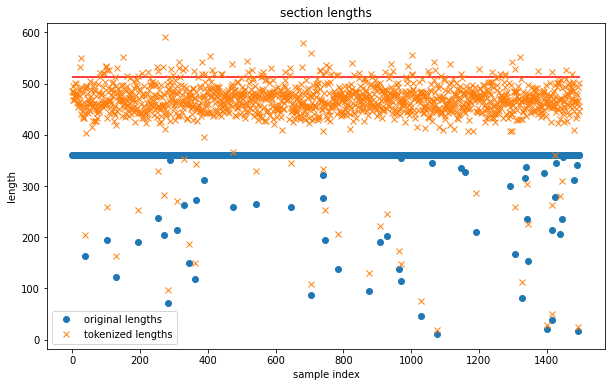

In [ ]:
# Find a suitable original sample length, given a max model input length of 512

max_input_length = 512
max_length, overlap = 360, 20

df = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv', group_id=True)
df = df.sample(100).reset_index(drop=True)
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train', df.Id)

cnt_pos, cnt_neg, ner_data = get_ner_data(papers, df, mark_title=True, mark_text=True,
                                          classlabel=get_ner_classlabel(), pretokenizer=BertPreTokenizer(), 
                                          sentence_definition='paper', max_length=max_length, overlap=overlap, 
                                          neg_keywords=['study', 'data'])
write_ner_json(ner_data, pth='train_ner.json')

datasets = load_ner_datasets(data_files={'train':'train_ner.json'})

tokenizer = create_tokenizer(model_checkpoint='roberta-base')
tokenized_input = tokenizer(datasets['train']['tokens'], truncation=False, is_split_into_words=True)

original_sample_lengths = np.array([len(tokens) for tokens in datasets['train']['tokens']])
tokenized_sample_lengths = np.array([len(input_ids) for input_ids in tokenized_input['input_ids']])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(original_sample_lengths, label='original lengths', linestyle='none', marker='o')
ax.plot(tokenized_sample_lengths, label='tokenized lengths', linestyle='none', marker='x')
ax.hlines(y=max_input_length, xmin=0, xmax=len(original_sample_lengths), color='red')
ax.set_ylabel('length')
ax.set_xlabel('sample index')
ax.set_title('section lengths')
ax.legend()

In [ ]:
#export
def tokenize_and_align_labels(examples, tokenizer=None, label_all_tokens=True):
    '''
    Adds a new field called 'labels' that are the NER tags to the tokenized input.
    
    Args:
        tokenizer (transformers.AutoTokenizer): Tokenizer.
        examples (datasets.arrow_dataset.Dataset): Dataset.
        label_all_tokens (bool): If True, all sub-tokens are given the same tag as the 
            first sub-token, otherwise all but the first sub-token are given the tag
            -100.
    '''
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    word_ids_all = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)
        word_ids_all.append(word_ids)

    tokenized_inputs["labels"] = labels
    tokenized_inputs['word_ids'] = word_ids_all
    return tokenized_inputs

In [ ]:
ner_data = [
    [('There', 0), ('is', 0), ('no', 0), ('dataset', 0), ('here', 0)], 
    [('Load', 0), ('the', 0), ('UN', 2), ('Trade', 1), ('Development', 1), ('into', 0), ('view', 0)]
]

write_ner_json(ner_data, pth=Path('/kaggle/tmp_ner.json'))
! cat /kaggle/tmp_ner.json

datasets = load_ner_datasets(data_files={'train':'/kaggle/tmp_ner.json', 'valid':'/kaggle/tmp_ner.json'})
tokenizer = create_tokenizer(model_checkpoint='roberta-base')

print()
print(tokenize_and_align_labels(datasets['train'][:], tokenizer, label_all_tokens=True), end='\n\n')

tokenized_datasets = datasets.map(
    partial(tokenize_and_align_labels, tokenizer=tokenizer, label_all_tokens=True), batched=True)
print(tokenized_datasets['valid'][:])
print(tokenized_datasets['train'].features)

{"tokens": ["There", "is", "no", "dataset", "here"], "ner_tags": [0, 0, 0, 0, 0]}
{"tokens": ["Load", "the", "UN", "Trade", "Development", "into", "view"], "ner_tags": [0, 0, 2, 1, 1, 0, 0]}


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-74665bfc7f072029/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.



{'input_ids': [[0, 970, 354, 2362, 36146, 281, 594, 10859, 2], [0, 47167, 627, 4154, 35996, 45297, 12473, 5877, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 0, 0, 0, 0, 0, 0, 0, -100], [-100, 0, 0, 2, 1, 1, 0, 0, -100]], 'word_ids': [[None, 0, 1, 2, 3, 3, 3, 4, None], [None, 0, 1, 2, 3, 4, 5, 6, None]]}




{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]], 'input_ids': [[0, 970, 354, 2362, 36146, 281, 594, 10859, 2], [0, 47167, 627, 4154, 35996, 45297, 12473, 5877, 2]], 'labels': [[-100, 0, 0, 0, 0, 0, 0, 0, -100], [-100, 0, 0, 2, 1, 1, 0, 0, -100]], 'ner_tags': [[0, 0, 0, 0, 0], [0, 0, 2, 1, 1, 0, 0]], 'tokens': [['There', 'is', 'no', 'dataset', 'here'], ['Load', 'the', 'UN', 'Trade', 'Development', 'into', 'view']], 'word_ids': [[None, 0, 1, 2, 3, 3, 3, 4, None], [None, 0, 1, 2, 3, 4, 5, 6, None]]}
{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(num_classes=3, names=['O', 'I', 'B'], names_file=None, id=None), length=-1, id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'word_ids': S

In [ ]:
# Save and load `datasets.dataset_dict.DatasetDict`
tokenized_datasets.save_to_disk('testsave_datasets')

In [ ]:
print(datasets.load_from_disk('testsave_datasets')['train']['input_ids'])
print(tokenized_datasets['train']['input_ids'])

[[0, 970, 354, 2362, 36146, 281, 594, 10859, 2], [0, 47167, 627, 4154, 35996, 45297, 12473, 5877, 2]]
[[0, 970, 354, 2362, 36146, 281, 594, 10859, 2], [0, 47167, 627, 4154, 35996, 45297, 12473, 5877, 2]]


In [ ]:
#export
def remove_nonoriginal_outputs(outputs, word_ids):
    '''
    Remove elements that correspond to special tokens or subtokens,
    retaining only those elements that correspond to a word in original
    text.
    
    Args:
        outputs (np.array): Each row are the label ids for the subtokens of
            a sample, with -100 indicating ignored subtokens, special tokens,
            or padding. 
        word_ids (list): Each element is a list of word ids which indicate the word
            that each subtoken belongs to. Each element corresponds to each row in `outputs`,
            though it could be shorter, since it's not padded like in `outputs`.
        
    Returns:
        outputs (list): Each element is a list of label ids for the 
            words in an sample. 
    '''
    assert len(outputs) == len(word_ids)
    idxs = [[word_id.index(i) for i in set(word_id) if i is not None] 
            for word_id in word_ids]
    outputs = [output[idx].tolist() for output, idx in zip(outputs, idxs)]
    for output in outputs:
        assert -100 not in output
    return outputs

In [ ]:
classlabel = get_ner_classlabel()

predictions = np.random.randn(2, 8, classlabel.num_classes)
predictions = np.argmax(predictions, axis=2)

label_ids = np.array([[-100, 0, 0,    2, 1,    2,    1, -100],
                      [-100, 2, 1, -100, 0, -100, -100, -100]])

word_ids = [[None, 0, 0, 1, 2, None],
            [None, 0, 1, 1, 2, 2, None]]

true_predictions = remove_nonoriginal_outputs(predictions, word_ids)
true_label_ids   = remove_nonoriginal_outputs(label_ids,   word_ids)

print('predictions')
print('BEFORE:')
print(predictions)
print('AFTER:')
print(true_predictions)
print(60 * '=')
print('label_ids')
print('BEFORE:')
print(label_ids)
print('AFTER:')
print(true_label_ids)

predictions
BEFORE:
[[2 1 0 1 0 1 1 0]
 [1 2 2 1 1 1 1 0]]
AFTER:
[[1, 1, 0], [2, 2, 1]]
label_ids
BEFORE:
[[-100    0    0    2    1    2    1 -100]
 [-100    2    1 -100    0 -100 -100 -100]]
AFTER:
[[0, 2, 1], [2, 1, 0]]


## Evaluation

In [ ]:
#export
def jaccard_similarity(s1, s2):
    l1 = set(s1.split(" "))
    l2 = set(s2.split(" "))
    intersection = len(list(l1.intersection(l2)))
    union = (len(l1) + len(l2)) - intersection
    return float(intersection) / union

In [ ]:
jaccard_similarity('USGS Frog Counts Data', 'USGA Croc Counts Data') == 1 / 3

True

In [ ]:
metric = load_metric('seqeval')

predictions = np.array([['O', 'O', 'B', 'I', 'I', 'O']])
references = [['O', 'O', 'B', 'I', 'I', 'O']]
print(metric.compute(predictions=predictions, references=references))

predictions = [['O', 'O', 'B', 'I', 'I', 'O']]
references = [['B', 'I', 'I', 'O', 'O', 'O']]
print(metric.compute(predictions=predictions, references=references))


{'_': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1}, 'overall_precision': 1.0, 'overall_recall': 1.0, 'overall_f1': 1.0, 'overall_accuracy': 1.0}
{'_': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1}, 'overall_precision': 0.0, 'overall_recall': 0.0, 'overall_f1': 0.0, 'overall_accuracy': 0.16666666666666666}


In [ ]:
#export
def compute_metrics(p, metric=None, word_ids=None, label_list=None):
    '''
    1. Remove predicted and ground-truth class ids of special and sub tokens.
    2. Convert class ids to class labels. (int ---> str)
    3. Compute metric.
    
    Args:
        p (tuple): 2-tuple consisting of model prediction and ground-truth
            labels.  These will contain elements corresponding to special 
            tokens and sub-tokens.
        word_ids (list): Word IDs from the tokenizer's output, indicating
            which original word each sub-token belongs to.
    '''
    predictions, label_ids = p
    predictions = predictions.argmax(axis=2)

    true_predictions = remove_nonoriginal_outputs(predictions, word_ids)
    true_label_ids = remove_nonoriginal_outputs(label_ids, word_ids)
    
    true_predictions = [[label_list[p] for p in pred] for pred in true_predictions]
    true_labels = [[label_list[i] for i in label_id] for label_id in true_label_ids]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
batch_size = 2
max_example_length = 6

predictions = np.random.randn(batch_size, max_example_length, classlabel.num_classes)
label_ids = np.random.randint(low=0, high=classlabel.num_classes, 
                              size=(batch_size, max_example_length), dtype=np.int16)
word_ids = [[None, 0, 0, 1, 2, None], 
            [None, 0, 1, None]]

print(predictions.argmax(axis=2))
print(label_ids)
p = (predictions, label_ids)
metric = load_metric('seqeval')
compute_metrics(p, metric=metric, label_list=classlabel.names, word_ids=word_ids)

[[1 1 1 1 0 0]
 [1 1 1 2 2 1]]
[[0 2 1 0 2 0]
 [0 2 2 1 1 0]]


{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.0}

# NER training

In [ ]:
train_meta = load_train_meta('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv').iloc[:3]
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/train', train_meta.Id)

valid_cutoff = int(.50 * len(train_meta))
valid_meta = train_meta.iloc[:valid_cutoff].reset_index(drop=True)
train_meta = train_meta.iloc[valid_cutoff:].reset_index(drop=True)

classlabel = get_ner_classlabel()
pretokenizer = BertPreTokenizer()

train_cnt_pos, train_cnt_neg, train_ner_data = get_ner_data(
    papers, df=train_meta, mark_title=True, mark_text=True,
    classlabel=classlabel, pretokenizer=pretokenizer,
    sentence_definition='section', max_length=360, overlap=20, neg_keywords=None)

valid_cnt_pos, valid_cnt_neg, valid_ner_data = get_ner_data(
    papers, df=valid_meta, mark_title=True, mark_text=True,
    classlabel=classlabel, pretokenizer=pretokenizer, 
    sentence_definition='section', max_length=360, overlap=20, neg_keywords=None)

print(f'Train.  Positive count: {train_cnt_pos}.  Negative count: {train_cnt_neg}.')
print(f'Valid.  Positive count: {valid_cnt_pos}.  Negative count: {valid_cnt_neg}.')

write_ner_json(train_ner_data, pth='train_ner.json')
write_ner_json(valid_ner_data, pth='valid_ner.json')
datasets = load_ner_datasets(data_files={'train':'train_ner.json', 'valid':'valid_ner.json'})

model_checkpoint = 'roberta-base' 
tokenizer = create_tokenizer(model_checkpoint)
tokenized_datasets = datasets.map(
    partial(tokenize_and_align_labels, tokenizer=tokenizer, label_all_tokens=True), batched=True)

tokenized_datasets.save_to_disk(f'datasetdict_{model_checkpoint}')

Training data size: 1 positives + 24 negatives: 100%|██████████| 1/1 [00:00<00:00, 50.23it/s]

Train.  Positive count: 3.  Negative count: 62.
Valid.  Positive count: 1.  Negative count: 24.


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-3ac5d3c26614f16f/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
model_checkpoint, bs = 'roberta-base', 10
# model_checkpoint, bs = 'distilbert-base-cased', 20
# model_checkpoint, bs = 'xlm-roberta-base', 8

tokenizer = create_tokenizer(model_checkpoint)
data_collator = DataCollatorForTokenClassification(tokenizer)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=classlabel.num_classes)
model.resize_token_embeddings(len(tokenizer))
metric = load_metric('seqeval')

tokenized_datasets = datasets.load_from_disk(f'datasetdict_{model_checkpoint}')
word_ids = tokenized_datasets['valid']['word_ids']
compute_metrics_ = partial(compute_metrics, metric=metric, label_list=classlabel.names, word_ids=word_ids)

args = TrainingArguments(output_dir='test_training', num_train_epochs=2, 
                         learning_rate=2e-5, weight_decay=0.01,
                         per_device_train_batch_size=bs, per_device_eval_batch_size=bs,
                         evaluation_strategy='epoch', logging_steps=4, report_to='none', 
                         save_strategy='epoch', save_total_limit=6)

trainer = Trainer(model=model, args=args, 
                  train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['valid'], 
                  data_collator=data_collator, tokenizer=tokenizer, compute_metrics=compute_metrics_)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Runtime,Samples Per Second
1,0.637400,0.026127,0.000000,0.000000,0.000000,0.998334,97.967200,0.255000
2,0.017100,0.015419,0.000000,0.000000,0.000000,0.998334,96.254700,0.260000


/opt/conda/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=14, training_loss=0.2064669385020222, metrics={'train_runtime': 1898.7417, 'train_samples_per_second': 0.007, 'total_flos': 48424503348270.0, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 208896, 'init_mem_cpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 3181748224, 'train_mem_cpu_peaked_delta': 9574674432})

In [ ]:
! ls -lrt test_training

total 8
drwxr-xr-x 2 root root 4096 Jun 19 05:07 checkpoint-7
drwxr-xr-x 2 root root 4096 Jun 19 05:23 checkpoint-14


In [ ]:
# bs = 4 # xlm-roberta-base on CPU
bs = 10 # distilbert-base-cased on CPU

args = TrainingArguments(output_dir='test_training', num_train_epochs=3, 
                         learning_rate=2e-5, weight_decay=0.01,
                         per_device_train_batch_size=bs, per_device_eval_batch_size=bs,
                         evaluation_strategy='epoch', logging_steps=4, report_to='none', 
                         save_strategy='epoch', save_total_limit=6)

trainer = Trainer(model=model, args=args, 
                  train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['valid'], 
                  data_collator=data_collator, tokenizer=tokenizer, 
                  compute_metrics=compute_metrics_)
trainer.train(resume_from_checkpoint='/kaggle/working/test_training/checkpoint-14/')

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Runtime,Samples Per Second
3,0.014000,0.014544,0.000000,0.000000,0.000000,0.998334,96.765800,0.258000


/opt/conda/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=21, training_loss=0.00444827051389785, metrics={'train_runtime': 964.2287, 'train_samples_per_second': 0.022, 'total_flos': 72701886742380.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 3388325888, 'train_mem_cpu_peaked_delta': 7161012224})

In [ ]:
trainer.evaluate()

/opt/conda/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.014544151723384857,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_accuracy': 0.9983340274885465,
 'eval_runtime': 96.5636,
 'eval_samples_per_second': 0.259,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 49152,
 'eval_mem_cpu_peaked_delta': 0}

## NER inference

**Turn off the Internet here**

In [ ]:
#export
def get_ner_inference_data(papers, sample_submission, 
                           mark_title=False, mark_text=False,
                           pretokenizer=BertPreTokenizer(), classlabel=get_ner_classlabel(), 
                           sentence_definition='sentence', max_length=64, overlap=20, 
                           min_length=10, contains_keywords=['data', 'study']):
    '''
    Args:
        papers (dict): Each list in this dictionary consists of the section of a paper.
        sample_submission (pd.DataFrame): Competition 'sample_submission.csv'.
        max_length (int): Maximum number of words allowed in a sentence.
        min_length (int): Mininum number of characters required in a sentence.
        
    Returns:
        test_rows (list): Each list in this list is of the form: 
             [('goat', 0), ('win', 0), ...] and represents a sentence.  
        paper_length (list): Number of sentences in each paper.
    '''
    test_rows = [] 
    paper_length = [] 

    for paper_id in sample_submission['Id']:
        paper = papers[paper_id]

        sentences = extract_sentences(paper, sentence_definition, mark_title, mark_text)
        sentences = [text2words(s, pretokenizer=pretokenizer) for s in sentences]
        sentences = shorten_sentences(sentences, max_length=max_length, overlap=overlap) 
        
        if min_length > 0:
            sentences = [
                sentence for sentence in sentences if len(' '.join(sentence)) > min_length] 
            
        if contains_keywords is not None:
            sentences = [
                sentence for sentence in sentences 
                if any(kw in ' '.join(word.lower() for word in sentence) for kw in contains_keywords)]

        for sentence in sentences:
            dummy_tags = [classlabel.str2int('O')]*len(sentence)
            test_rows.append(list(zip(sentence, dummy_tags)))

        paper_length.append(len(sentences))

    print(f'total number of "sentences": {len(test_rows)}')
    return test_rows, paper_length

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/test', sample_submission.Id)

classlabel = get_ner_classlabel()
pretokenizer = BertPreTokenizer()
test_rows, paper_length = get_ner_inference_data(papers, sample_submission, 
                                                 mark_title=True, mark_text=True,
                                                 classlabel=classlabel, pretokenizer=pretokenizer,
                                                 sentence_definition='paper', max_length=360, overlap=20,
                                                 min_length=0, contains_keywords=['data'])
print(test_rows[0])
print(paper_length)

total number of "sentences": 106
[('AAAsTITLE', 0), ('Abstract', 0), ('ZZZsTITLE', 0), ('AAAsTEXT', 0), ('Cognitive', 0), ('deficits', 0), ('and', 0), ('reduced', 0), ('educational', 0), ('achievement', 0), ('are', 0), ('common', 0), ('in', 0), ('psychiatric', 0), ('illness', 0), (';', 0), ('understanding', 0), ('the', 0), ('genetic', 0), ('basis', 0), ('of', 0), ('cognitive', 0), ('and', 0), ('educational', 0), ('deficits', 0), ('may', 0), ('be', 0), ('informative', 0), ('about', 0), ('the', 0), ('etiology', 0), ('of', 0), ('psychiatric', 0), ('disorders', 0), ('.', 0), ('A', 0), ('recent', 0), (',', 0), ('large', 0), ('genomewide', 0), ('association', 0), ('study', 0), ('(', 0), ('GWAS', 0), (')', 0), ('reported', 0), ('a', 0), ('genome', 0), ('-', 0), ('wide', 0), ('significant', 0), ('locus', 0), ('for', 0), ('years', 0), ('of', 0), ('education', 0), (',', 0), ('which', 0), ('subsequently', 0), ('demonstrated', 0), ('association', 0), ('to', 0), ('general', 0), ('cognitive', 0), ('

In [ ]:
#export
def ner_predict(pth=None, tokenizer=None, model=None, metric=None, 
                per_device_train_batch_size=16, per_device_eval_batch_size=16):
    classlabel = get_ner_classlabel()
    datasets = load_ner_datasets(data_files={'test':pth})

    print('Tokenizing testset...', end='')
    t0 = time.time()
    tokenized_datasets = datasets.map(
        partial(tokenize_and_align_labels, tokenizer=tokenizer, label_all_tokens=True), 
        batched=True)
    print(f'completed in {(time.time() - t0) / 60:.2f} mins.')
    
    print('Creating data collator...')
    data_collator = DataCollatorForTokenClassification(tokenizer)
    
    print('Creating (dummy) training arguments...')
    args = TrainingArguments(output_dir='test_ner', num_train_epochs=3, 
                             learning_rate=2e-5, weight_decay=0.01,
                             per_device_train_batch_size=per_device_train_batch_size, 
                             per_device_eval_batch_size=per_device_eval_batch_size,
                             evaluation_strategy='epoch', logging_steps=4, report_to='none', 
                             save_strategy='epoch', save_total_limit=6)

    print('Creating trainer...')
    word_ids = tokenized_datasets['test']['word_ids']
    compute_metrics_ = partial(compute_metrics, metric=metric, label_list=classlabel.names, word_ids=word_ids)
    trainer = Trainer(model=model, args=args, 
                      train_dataset=tokenized_datasets['test'], eval_dataset=tokenized_datasets['test'], 
                      data_collator=data_collator, tokenizer=tokenizer, compute_metrics=compute_metrics_)

    print('Predicting on test samples...')
    t0 = time.time()
    predictions, label_ids, _ = trainer.predict(tokenized_datasets['test'])
    print(f'completed in {(time.time() - t0) / 60:.2f} mins.')
    print('Argmaxing...')
    t0 = time.time()
    predictions = predictions.argmax(axis=2)
    print(f'completed in {(time.time() - t0) / 60:.2f} mins.')
    
    print('Removing non-original outputs...', end='')
    t0 = time.time()
    predictions = remove_nonoriginal_outputs(predictions, word_ids)
    label_ids   = remove_nonoriginal_outputs(label_ids, word_ids)
    print(f'completed in {(time.time() - t0) / 60:.2f} mins.')
    
    return predictions, label_ids

In [ ]:
# This shows where to look for the cached metric `seqeval`.
# metric = load_metric('/root/.cache/huggingface/modules/datasets_modules/metrics/seqeval/ec5b7242a8c40468d189ca0b2b10612578dbcad311b2a134c99e3ded58a0d6e3/seqeval.py')

# Exporting the cached metric 

# %cd /root/.cache
# ! zip -r huggingface_cache.zip huggingface/modules/datasets_modules/metrics/seqeval/ec5b7242a8c40468d189ca0b2b10612578dbcad311b2a134c99e3ded58a0d6e3/
# %cd 

In [ ]:
samples = ['''Archaeologists estimate the carvings are between 4,000 and 5,000 years old''', 
           ('''I could see that I was looking at a deer stag upside down, '''
            '''and as I continued looking around, more animals appeared on the rock,” he said.''')]

samples = [text2words(sample, pretokenizer=BertPreTokenizer()) for sample in samples]
test_rows = [list(zip(sample, len(sample) * [0])) for sample in samples]
write_ner_json(test_rows, pth='test_ner.json')

model_checkpoint = 'test_training/checkpoint-21/'
tokenizer = create_tokenizer(model_checkpoint=model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)
metric = load_metric('/root/.cache/huggingface/modules/datasets_modules/metrics/seqeval/ec5b7242a8c40468d189ca0b2b10612578dbcad311b2a134c99e3ded58a0d6e3/seqeval.py')

predictions, label_ids = ner_predict(pth='test_ner.json', tokenizer=tokenizer, model=model, metric=metric, 
                                     per_device_train_batch_size=4, per_device_eval_batch_size=4)


for i in range(len(predictions)):
    print(f'Sample {i}:', len(predictions[i]), len(label_ids[i]), len(samples[i]))

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-d53c998af712123f/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
Tokenizing testset...

AssertionError: You need to instantiate RobertaTokenizerFast with add_prefix_space=True to use it with pretokenized inputs.

In [ ]:
#export

def batched_ner_predict(pth, tokenizer=None, model=None, metric=None, 
                        batch_size=64_000, 
                        per_device_train_batch_size=16, per_device_eval_batch_size=16):
    '''
    Do inference on dataset in batches.
    '''
    lines = open(pth, mode='r').readlines()
    
    pth_tmp = 'ner_predict_tmp.json'
    predictions, label_ids = [], []
    for ib in range(0, len(lines), batch_size):
        with open(pth_tmp, mode='w') as f:
            f.writelines(lines[ ib: ib + batch_size ])

        predictions_, label_ids_ = ner_predict(
            pth_tmp, tokenizer=tokenizer, model=model, metric=metric, 
            per_device_train_batch_size=per_device_train_batch_size, 
            per_device_eval_batch_size=per_device_eval_batch_size)
        predictions.extend(predictions_)
        label_ids.extend(label_ids_)
    return predictions, label_ids

In [ ]:
samples = ['''Archaeologists estimate the carvings are between 4,000 and 5,000 years old''', 
           ('''I could see that I was looking at a deer stag upside down, '''
            '''and as I continued looking around, more animals appeared on the rock,” he said.'''),
           '''The RNN model we are about to build has LSTM cells as basic hidden units.''', 
           '''YouTube series, the Crooner Sessions. Now he gets his musical pals together in real life for ''']

samples = [text2words(sample, pretokenizer=BertPreTokenizer()) for sample in samples]
test_rows = [list(zip(sample, len(sample) * [0])) for sample in samples]
write_ner_json(test_rows, pth='test_ner.json')

model_checkpoint = 'test_training/checkpoint-21/'
tokenizer = create_tokenizer(model_checkpoint=model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)
metric = load_metric('/root/.cache/huggingface/modules/datasets_modules/metrics/seqeval/ec5b7242a8c40468d189ca0b2b10612578dbcad311b2a134c99e3ded58a0d6e3/seqeval.py')

predictions, label_ids = batched_ner_predict(
    'test_ner.json', tokenizer=tokenizer, model=model, metric=metric, batch_size=2, 
    per_device_train_batch_size=16, per_device_eval_batch_size=16)


for i in range(len(predictions)):
    print(f'Sample {i}:', len(predictions[i]), len(label_ids[i]), len(samples[i]))

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-2cb3b605ce2249d0/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
Tokenizing testset...

AssertionError: You need to instantiate RobertaTokenizerFast with add_prefix_space=True to use it with pretokenized inputs.

In [ ]:
#export
def get_paper_dataset_labels(pth, paper_length, predictions):
    '''
    Args:
        pth (Path, str): Path to json file containing NER data.  Each row is 
            of form: {'tokens': ['Studying', 'human'], 'ner_tags': [0, 0, ...]}.
    
    Returns:
        paper_dataset_labels (list): Each element is a set consisting of labels predicted
            by the model.
    '''
    test_sentences = [json.loads(sample)['tokens'] for sample in open(pth).readlines()]
    
    paper_dataset_labels = [] # store all dataset labels for each publication
    for ipaper in range(len(paper_length)):
        istart = sum(paper_length[:ipaper])
        iend = istart + paper_length[ipaper]
        
        labels = set()
        for sentence, pred in zip(test_sentences[istart:iend], predictions[istart:iend]):
            curr_phrase = ''
            for word, tag in zip(sentence, pred):
                if tag == 'B': # start a new phrase
                    if curr_phrase:
                        labels.add(curr_phrase)
                        curr_phrase = ''
                    curr_phrase = word
                elif tag == 'I' and curr_phrase: # continue the phrase
                    curr_phrase += ' ' + word
                else: # end last phrase (if any)
                    if curr_phrase:
                        labels.add(curr_phrase)
                        curr_phrase = ''
            # check if the label is the suffix of the sentence
            if curr_phrase:
                labels.add(curr_phrase)
                curr_phrase = ''

        # record dataset labels for this publication
        paper_dataset_labels.append(labels)

    return paper_dataset_labels

In [ ]:
sentences = ['They do not present all the features', 
             'Despite the pretraining on the Tigers EcoNAX dataset',
             'Weirdly there has been lots of studies based on WGS Equality Definitiveness Dataset']
paper_length = [2, 1]
test_rows = [[(word, 0) for word in sentence.split()] for sentence in sentences]
predictions = [['O', 'O', 'O', 'B', 'I', 'I', 'O'],
               ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'I'],
               ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I']]
for i, row in enumerate(test_rows):
    assert len(row) == len(predictions[i])

write_ner_json(test_rows, pth='test_ner.json')

paper_dataset_labels = get_paper_dataset_labels('test_ner.json', paper_length, predictions)
print(paper_dataset_labels)

[{'Tigers EcoNAX dataset', 'present all the'}, {'WGS Equality Definitiveness Dataset'}]


# Literal matching

In [ ]:
#export
def create_knowledge_bank(pth):
    '''
    Args:
        pth (str): Path to meta data like 'train.csv', which
        needs to have columns: 'dataset_title', 'dataset_label', and 'cleaned_label'.
        
    Returns:
        all_labels (set): All possible strings associated with a dataset from the meta data.
    '''
    df = load_train_meta(pth, group_id=False)
    all_labels = set()
    for label_1, label_2, label_3 in df[['dataset_title', 'dataset_label', 'cleaned_label']].itertuples(index=False):
        all_labels.add(str(label_1).lower())
        all_labels.add(str(label_2).lower())
        all_labels.add(str(label_3).lower())
    return all_labels

In [ ]:
pth = Path('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv')

print('Creating knowledge bank...', end='')
t0 = time.time()
knowledge_bank = create_knowledge_bank(pth)
print(f'completed in {time.time() - t0:.4f} s.')

print(len(knowledge_bank))
print(sorted(knowledge_bank)[:10])

Creating knowledge bank...completed in 0.0909 s.
180
['2019 ncov complete genome sequences', '2019 ncov genome sequence', '2019 ncov genome sequences', '2019-ncov complete genome sequences', '2019-ncov genome sequence', '2019-ncov genome sequences', 'adni', 'advanced national seismic system (anss) comprehensive catalog (comcat)', 'advanced national seismic system anss comprehensive catalog comcat ', 'advanced national seismic system comprehensive catalog']


In [ ]:
#export
def literal_match(paper, all_labels):
    '''
    Args:
        paper ()
    '''
    text_1 = '. '.join(section['text'] for section in paper).lower()
    text_2 = clean_training_text(text_1, lower=True, total_clean=True)
    
    labels = set()
    for label in all_labels:
        if label in text_1 or label in text_2:
            labels.add(clean_training_text(label, lower=True, total_clean=True))
    return labels

In [ ]:
pth = Path('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv')
knowledge_bank = create_knowledge_bank(pth)

sample_submission = pd.read_csv('/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/test/', sample_submission.Id)

literal_preds = [literal_match(papers[paper_id], knowledge_bank) for paper_id in sample_submission.Id]
print(literal_preds)

[{'alzheimer s disease neuroimaging initiative adni', 'adni'}, {'trends in international mathematics and science study', 'common core of data', 'nces common core of data'}, {'sea lake and overland surges from hurricanes', 'noaa storm surge inundation', 'slosh model'}, {'rural urban continuum codes'}]


# Overall prediction for submission

In [ ]:
#export
def combine_matching_and_model(literal_preds, paper_dataset_labels):
    '''
    Args:
        literal_preds (list): Each element is a set, containing predicted labels for a paper
            using literal matching.
        paper_dataset_labels (list): Each element is a set, containing predicted labels for 
            a paper using trained model.
    Returns:
        filtered_dataset_labels (list): Each element is a string, containing 
            labels seperated by '|'.  
            
    Notes:
        Combine literal matching predictions and model predictions. 
        Literal match predictions are appended IN FRONT of the model predictions,
        because literal matches will be kept when removing labels that are too
        similar to each other.
    '''
    all_labels = [list(literal_match) + list(model_pred) 
                  for literal_match, model_pred in zip(literal_preds, paper_dataset_labels)]
    return all_labels

In [ ]:
literal_preds = [
    {'mongolian racing cars', 'reallife headphones'}, 
    {},
    {'rhs flowers fertiliser index'}, 
    {'moma artists catalogue'}]

paper_dataset_labels = [
    {'data', 'dataset'}, 
    {'hifi dataset', 'headphones collection data'}, 
    {'deep sea rock salts', 'rhs fertiliser index'}, 
    {'moma artists', 'housing market'}]

combine_matching_and_model(literal_preds, paper_dataset_labels)

[['mongolian racing cars', 'reallife headphones', 'dataset', 'data'],
 ['hifi dataset', 'headphones collection data'],
 ['rhs flowers fertiliser index',
  'deep sea rock salts',
  'rhs fertiliser index'],
 ['moma artists catalogue', 'housing market', 'moma artists']]

In [ ]:
#export
def filter_dataset_labels(all_labels, max_similarity=0.75):
    '''
    When several labels for a paper are too similar, keep just one of them,
    the one that appears FIRST.
    
    Args:
        all_labels (list, set): Each element is a list of labels (str).
        
    Returns:
        filtered_dataset_labels (list): Each element is a string, containing 
            labels seperated by '|'.
    '''
    filtered_dataset_labels = []

    for labels in all_labels:
        filtered = []

        for label in labels:
            label = clean_training_text(label, lower=True)
            if len(filtered) == 0 or all(jaccard_similarity(label, got_label) < max_similarity 
                                         for got_label in filtered):
                filtered.append(label)

        filtered_dataset_labels.append('|'.join(filtered))
    return filtered_dataset_labels

In [ ]:
all_labels = [
    ['moma artists catalogue', 'moma artists', 'housing market'],
    ['rhs flowers fertiliser index', 'deep sea rock salts', 'rhs fertiliser index']]
print(filter_dataset_labels(all_labels, max_similarity=.9))

print()

all_labels = [
    {'moma artists catalogue', 'moma artists', 'housing market'},
    {'rhs flowers fertiliser index', 'deep sea rock salts', 'rhs fertiliser index'}]
print(filter_dataset_labels(all_labels))

['moma artists catalogue|moma artists|housing market', 'rhs flowers fertiliser index|deep sea rock salts|rhs fertiliser index']

['moma artists catalogue|moma artists|housing market', 'rhs flowers fertiliser index|deep sea rock salts']


Inference script

In [ ]:
! cp ../input/huggingface-cache/huggingface/modules/datasets_modules/metrics/seqeval/ec5b7242a8c40468d189ca0b2b10612578dbcad311b2a134c99e3ded58a0d6e3/seqeval.py .

model_checkpoint = './test_training/checkpoint-21'

print('Preparing NER inference data...')
sample_submission = pd.read_csv('/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
papers = load_papers('/kaggle/input/coleridgeinitiative-show-us-the-data/test/', sample_submission.Id)
classlabel = get_ner_classlabel()
pretokenizer = BertPreTokenizer()
test_rows, paper_length = get_ner_inference_data(papers, sample_submission, 
                                                 classlabel=classlabel, pretokenizer=pretokenizer,
                                                 sentence_definition='section', max_length=300, overlap=20,
                                                 min_length=0, contains_keywords=None)
write_ner_json(test_rows, pth='test_ner.json')

print('Loading model, tokenizer, and metric...')
tokenizer = create_tokenizer(model_checkpoint=model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)
metric = load_metric('seqeval.py')

print('Predicting on each sentence...')
predictions, label_ids = batched_ner_predict(
    'test_ner.json', tokenizer=tokenizer, model=model, metric=metric, batch_size=64_000, 
    per_device_train_batch_size=20, per_device_eval_batch_size=20)
predictions = [[classlabel.int2str(p) for p in pred] for pred in predictions]
label_ids   = [[classlabel.int2str(l) for l in label] for label in label_ids]

print('Getting predicted labels for each article...')
paper_dataset_labels = get_paper_dataset_labels('test_ner.json', paper_length, predictions)

print('String matching...')
knowledge_bank = create_knowledge_bank('/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv')
literal_preds = []
for paper_id in sample_submission.Id:
    literal_preds.append(literal_match(papers[paper_id], knowledge_bank))

print('Combining literal matches and model predictions...')
all_labels = combine_matching_and_model(literal_preds, paper_dataset_labels)

print('Keeping just one of labels that are too similar to each other...')
filtered_dataset_labels = filter_dataset_labels(all_labels)

sample_submission['PredictionString'] = filtered_dataset_labels

sample_submission.to_csv('submission.csv', index=False)

Preparing NER inference data...
total number of "sentences": 289
Loading model, tokenizer, and metric...
Predicting on each sentence...


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-bb25954f4e3f0e3e/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
Tokenizing testset...

AssertionError: You need to instantiate RobertaTokenizerFast with add_prefix_space=True to use it with pretokenized inputs.

In [ ]:
! cat submission.csv

cat: submission.csv: No such file or directory


# Error analysis

In [ ]:
model_checkpoint = '../input/showusdata-distilbert-base-cased-ner/training_results_distilbert-base-cased/checkpoint-56997'
pth_valid_json = '../input/showus-data-ner-jsons/valid_ner.json'

ner_data_valid = random.sample(open(pth_valid_json).readlines(), 20)
ner_data_valid = [json.loads(sample) for sample in ner_data_valid]
ner_data_valid = [list(zip(sample['tokens'], sample['ner_tags'])) for sample in ner_data_valid]
write_ner_json(ner_data_valid, pth='valid_ner.json')

tokenizer = create_tokenizer(model_checkpoint=model_checkpoint)
classlabel = get_ner_classlabel()
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=classlabel.num_classes)
metric = load_metric('seqeval')

predictions, label_ids = ner_predict(pth='valid_ner.json', tokenizer=tokenizer, model=model, metric=metric, 
                                     per_device_train_batch_size=4, per_device_eval_batch_size=4)
predictions = [[classlabel.int2str(p) for p in pred] for pred in predictions]
label_ids   = [[classlabel.int2str(l) for l in label] for label in label_ids]

paper_dataset_labels = get_paper_dataset_labels('valid_ner.json', len(predictions) * [1], predictions)
gt_paper_dataset_labels = get_paper_dataset_labels('valid_ner.json', len(label_ids) * [1], label_ids)

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-8bf2ac7e4c4577b4/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
Tokenizing testset...


completed in 0.00 mins.
Creating data collator...
Creating (dummy) training arguments...
Creating trainer...
Predicting on test samples...


completed in 0.58 mins.
Argmaxing...
completed in 0.00 mins.
Removing non-original outputs...completed in 0.00 mins.


In [ ]:
for predicted_labels, gt_labels in zip(paper_dataset_labels, gt_paper_dataset_labels):
    if gt_labels:
        print(predicted_labels, gt_labels)

{'ADNI'} {'ADNI'}
{'ADNI'} {'ADNI'}


In [ ]:
metric.compute(predictions=predictions, references=label_ids)

{'_': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

# References
- https://www.kaggle.com/tungmphung/pytorch-bert-for-named-entity-recognition/notebook
- https://www.kaggle.com/tungmphung/coleridge-matching-bert-ner/notebook
- https://github.com/huggingface/notebooks/blob/master/examples/token_classification.ipynb
- https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
- https://huggingface.co/docs/datasets/loading_metrics.html
- [Python strings and memory](https://rushter.com/blog/python-strings-and-memory/)
- [Grandmaster Series – Building World-Class NLP Models with Transformers and Hugging Face](https://www.kaggle.com/c/commonlitreadabilityprize/discussion/245004)
- https://huggingface.co/transformers/tokenizer_summary.html
- https://discuss.huggingface.co/t/t5-seq2seq-custom-fine-tuning/1497/4
- https://www.kaggle.com/c/google-quest-challenge/discussion/123770